In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qspectro2d.spectroscopy import complex_polarization

# Constants
t_coh = 300          # fs
t_wait = 1000          # fs
pulse_width = 15       # fs (FWHM)
t_det_max = 600        # fs
n_freqs = 10          # ensemble samples
delta_cm = 200         # inhomogeneous FWHM in cm^-1
center_cm = 16000      # center frequency in cm^-1

T1 = 300  # fs
T2_star = 100  # fs

c_fs = 2.998e-5        # cm/fs
omega_0 = 2 * np.pi * center_cm * c_fs  # rad/fs
omega_L = omega_0  # laser frequency
delta_omega = 2 * np.pi * delta_cm * c_fs
dt = 2
t_max = t_coh + t_wait + t_det_max
times = np.linspace(0, t_max, int((t_max) / dt) + 1)

# System operators
g, e = basis(2, 0), basis(2, 1)
H0 = omega_0 * e * e.dag()
mu = e * g.dag() + g * e.dag()

# Gaussian pulse envelope
def pulse(t, t0, phi=0):
    envelope = np.exp(-4 * np.log(2) * ((t - t0) / pulse_width) ** 2)
    return envelope * np.exp(-1j * (omega_L * t - phi))  # complex field

# Full Hamiltonian with pulses
def H_total(t, omega):
    E1 = pulse(t, 0, phi=0)  # pi/2 phase shift for first pulse
    E2 = pulse(t, t_coh, phi=np.pi / 2)  # pi/2 phase shift for second pulse
    E3 = 0.1 * pulse(t, t_coh + t_wait)
    
    H = omega * e * e.dag() - mu * (E1 + E2 + E3)
    return H

# Solve dynamics for a single realization
from qspectro2d.core import AtomicSystem
def simulate_single(omega_shift):
    system = AtomicSystem(
        N_atoms=1,
        atom_g=g,
        atom_e=e,
        omega_laser_cm=center_cm
    )
    options = {
        'store_states': True,
    }
    H = [lambda t, args: H_total(t, omega_0 + omega_shift)]

    # Add decoherence
    gamma_relax = 1 / T1
    gamma_dephase = 1 / T2_star

    c_ops = [
        np.sqrt(gamma_relax) * g * e.dag(),   # T1 decay
        np.sqrt(gamma_dephase) * e * e.dag()  # pure dephasing
    ]

    rho0 = g * g.dag()
    result = mesolve(H, rho0, times, c_ops, options=options)
    dipole_op = system.dipole_op
    return complex_polarization(dipole_op, result.states)


# === CASE A: Homogeneous ===
signal_hom = simulate_single(0.0)

# === CASE B: Inhomogeneous ===
shifts = np.random.normal(loc=0.0, scale=delta_omega / (2 * np.sqrt(2 * np.log(2))), size=n_freqs)
signals = np.array([simulate_single(dw) for dw in shifts])
signal_inhom = np.mean(signals, axis=0)



LaTeX: not available -> using mathtext


TypeError: AtomicSystem.__init__() got an unexpected keyword argument 'N_atoms'

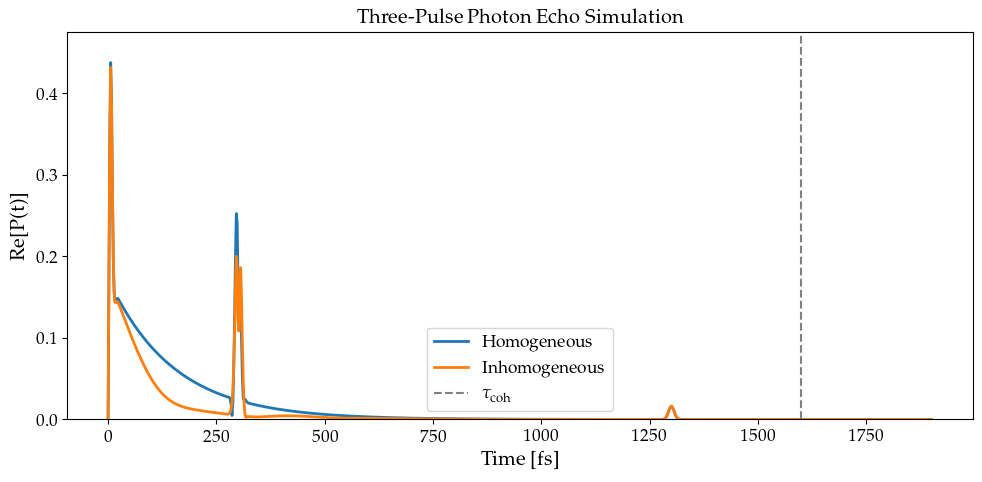

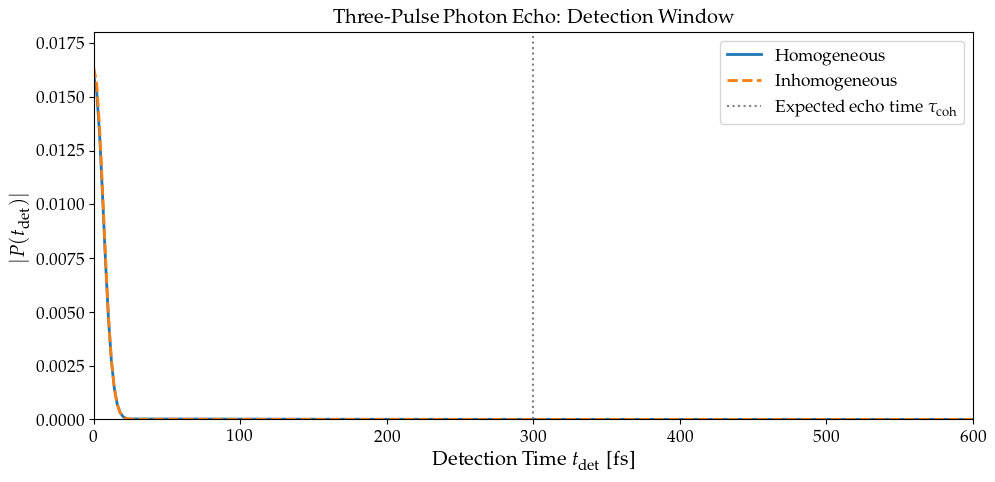

In [ ]:
# === Plot ===
plt.figure(figsize=(10, 5))
plt.plot(times, np.abs(signal_hom), label="Homogeneous", lw=2)
plt.plot(times, np.abs(signal_inhom), label="Inhomogeneous", lw=2)
plt.axvline(t_wait+2*t_coh, color='gray', ls='--', label=r"$\t_{det}{\mathrm{coh}}$")
plt.xlabel("Time [fs]")
plt.ylabel("Re[P(t)]")
plt.legend()
plt.title("Three-Pulse Photon Echo Simulation")
plt.tight_layout()
plt.ylim(0, 1.1*np.max(np.abs(signal_inhom)))
plt.show()

# Create detection time values array
t_det_vals = np.linspace(0, t_det_max, int(t_det_max / dt) + 1)

# Take the last portion of signals that match the length of t_det_vals
detection_start_idx = np.argmin(np.abs(times - (t_coh + t_wait)))
t_det_vals = times[detection_start_idx:] - (t_coh + t_wait)  # Shift time to start at 0
signal_hom_det = signal_hom[detection_start_idx:]
signal_inhom_det = signal_inhom[detection_start_idx:]

# === Plot Detection Window ===
plt.figure(figsize=(10, 5))
plt.plot(t_det_vals, np.abs(signal_hom_det), label="Homogeneous", color='C0', linestyle='solid', lw=2)
plt.plot(t_det_vals, np.abs(signal_inhom_det), label="Inhomogeneous", color='C1', linestyle='dashed', lw=2)
# Calculate where the echo should appear - at t_coh after the third pulse
echo_time = t_coh
plt.axvline(echo_time, color='gray', ls='dotted', label=r"Expected echo time $\t_{det}{\mathrm{coh}}$")
plt.xlabel(r"Detection Time $t_{\mathrm{det}}$ [fs]")
plt.ylabel(r"$|P(t_{\mathrm{det}})|$")
plt.legend()
plt.title(r"Three-Pulse Photon Echo: Detection Window")
plt.tight_layout()
plt.xlim(0, t_det_max)
plt.ylim(0, 1.1*np.max(np.abs(signal_inhom_det)))
plt.show()